In [36]:
# работа с таблицами
import numpy as np
import pandas as pd
# импорт данных
import json
# отображение текстовых данных по ширине окна
import textwrap
# проверка на наличие эмодзи
import emoji
# очистка текста
import re
import string
# лемматизация
import pymorphy3
# векторизация текста
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import time

import matplotlib.pyplot as plt

import mplcyberpunk

plt.style.use("cyberpunk")

import pickle

In [2]:
with open("/home/artemiy/nlp_project/data/restaurants_reviews.jsonl", "r") as file:
    data_list = []
    for line in file:
        data = json.loads(line)
        data_list.append(data)

In [3]:
df = pd.DataFrame(data_list)
df.head()

,review_id,general,food,interior,service,text
0,0,0,10,10,10,Вытянули меня сегодня в город и раз уж была в ...
1,1,0,9,10,9,проводили корпоратив на 60 чел. в этот - уже т...
2,2,0,9,10,10,Был в Гостях с женой один раз и еще раз с жено...
3,3,0,-,5,10,Бар понравился на первый взгляд . Интерьер к ...
4,4,0,7,10,10,В « Bel Canto » мы отмечали юбилей моего отца ...


In [4]:
df['general'].value_counts()

general
0    43940
5     2164
1      462
4      257
2      166
3      150
Name: count, dtype: int64

In [5]:
filtered_data = df[df['general']!= 0]

In [6]:
filtered_data

,review_id,general,food,interior,service,text
34000,34000,5,0,0,0,Самый офигенный клуб в Москве . Таких клубов ...
34038,34038,5,0,0,0,отмечали юбилей своей мамочки . он был 05.09.2...
34039,34039,5,0,0,0,"Решил оставить отзыв , пока впечатления еще св..."
34040,34040,5,0,0,0,08.09.12 праздновали в ресторане Palati свадьб...
34041,34041,3,0,0,0,были в кафе Пушкин 16 сентября . Приводили на...
...,...,...,...,...,...,...
37632,37632,4,0,0,0,Посетила это место совсем недавно и была удивл...
37633,37633,1,0,0,0,В данном заведении Вы скорее всего не отравите...
37634,37634,5,0,0,0,Доброго времени суток всем ! На этом замечате...
37635,37635,5,0,0,0,Я хотела от лица всех наших гостей и себя личн...


(array([ 462.,    0.,  166.,    0.,    0.,  150.,    0.,  257.,    0.,
        2164.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

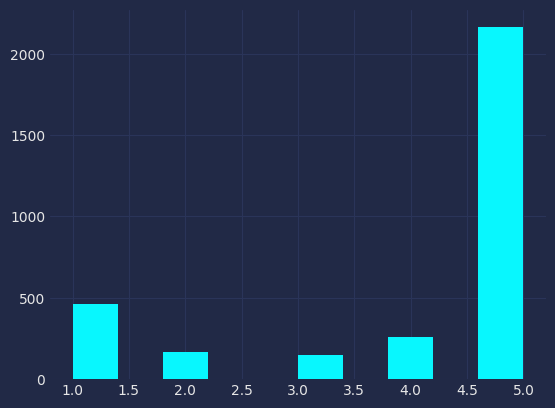

In [7]:
plt.hist(filtered_data['general'])

In [40]:
print(textwrap.fill(df['text'][5]))

Здравствуйте , уважаемые женихи и невесты .  Год назад писал отзыв ,
но из-за глюка его не разместили , я расстроился и забил на это дела .
Сейчас нахлынули воспоминания , и решил всё-таки отблагодарить
ресторан своим отзывом .  Как и все долго выбирали ресторан , когда
пришли в Неву-холл жене он понравилась , а я как-то не впечатлился .
Ещё долго ходили по огромному списку ресторанов , и всё-таки
остановились на нём .  Ради справедливости скажу , что во второй
приход он мне понравился .  От ресторана сопровождал наш праздник
Владимир .  Пока за свои 25 в сфере обслуживания я встречал двух
профессионалов , так вот Владимир один из них .  Он доступно всё
объяснял , был тактичен и не навешивал услуги , а давал грамотные
советы .  Он посоветовал своих оформителей и ведущего с ди-джеем .  С
оформителем вышел небольшой конфуз так как не оказалось нужных цветов
, но вопрос быстро решили .  В итоге не без помощи Владимира , нам
сделали отличное оформление , и букет + чтобы мы остались довольн

In [8]:
with open(
    "/home/artemiy/nlp_project/data/stopwords-ru.txt", "r", encoding="utf-8"
) as file:
    stop_words = set(file.read().split())

In [9]:
def has_emoji(text):
    for character in text:
        if character in emoji.demojize(text):
            return 'эмодзи детектед'
    return 'эмодзи не обнаружен'

In [13]:
filtered_data.isna().sum()

review_id    0
general      0
food         0
interior     0
service      0
text         0
dtype: int64

In [14]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
    "\U00002700-\U000027BF"  # Dingbats
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U00002600-\U000026FF"  # Miscellaneous Symbols
    "\U00002B50-\U00002B55"  # Miscellaneous Symbols and Pictographs
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U0001F700-\U0001F77F"  # Alchemical Symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "]+",
    flags=re.UNICODE,
)

In [15]:
def clean(text, stop__words):
    text = text.lower()  # нижний регистр
    text = re.sub(r"http\S+", " ", text)  # удаляем ссылки
    text = re.sub(r"@\w+", " ", text)  # удаляем упоминания пользователей
    text = re.sub(r"#\w+", " ", text)  # удаляем хэштеги
    text = re.sub(r"\d+", " ", text)  # удаляем числа
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"<.*?>", " ", text)  #
    text = re.sub(r"[️«»—]", " ", text)
    text = re.sub(r"[^а-яё ]", " ", text)
    text = text.lower()
    text = emoji_pattern.sub(r"", text)
    text = " ".join([word for word in text.split() if word not in stop__words])
    return text

In [16]:
clean_text = [clean(text, stop_words) for text in filtered_data["text"]]

In [17]:
print(textwrap.fill(clean_text[1310]))

верится вкусно интересно добрый персонал приятно удивлен


In [18]:
morph = pymorphy3.MorphAnalyzer()

In [19]:
def lemmatize(text):
    words = text.split()
    lem_words = [morph.parse(word)[0].normal_form for word in words]
    return " ".join(lem_words)

In [20]:
lem_text = [lemmatize(text) for text in clean_text]

In [22]:
len(clean_text)

3199

In [23]:
print(textwrap.fill(clean_text[2500]))

отвратительно вечера кухня бар работают подойдут попросят закрыть счет
разгаре меню вечера работает всей еды картошка фри крепкого алкоголя
набьют чек лишних позиций пьяны оплатите перебивали чек раза вообщем
советую либо владельцев отсутствует опыт понятие сервиса знакомо либо
устраивает убыточный бизнес


In [18]:
print(textwrap.fill(lem_text[130]))

жаловаться отвратительный работа ресторанапивоварня балтика брю
расположить адрес ул больший морской ходить вечером заставить
заплатить разбитый посуда какоголибо акт счёт руб оплатить охрана
предупредить охрана давать преградить хамить оскорблять ч матерно
вступить драка ход пострадать ребята сильно избить девушка девушка
увезти скорый ребята повезти травма вызвать полиция написать заявление
заплатить заведение результат получить морда


In [34]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    ngram_range=(1,3)
)

X_tfidf = vectorizer.fit_transform(lem_text)

In [35]:
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")

Shape of TF-IDF matrix: (3199, 5630)


In [26]:
y = filtered_data['general'].values

In [27]:
y.shape

(3199,)

In [37]:
# поиск потимальных параметров
# для логрег
param_grid_logreg = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "lbfgs", "saga"],
}
# Для SVM
param_grid_svm = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", 0.01, 0.1, 1, 10],
}
# Для Random Forest
param_grid_forest = {
    "n_estimators": [100, 200, 500, 1000],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [39]:
grid_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5)
grid_logreg.fit(X_train, y_train)
grid_svm = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
grid_forest = GridSearchCV(
    RandomForestClassifier(random_state=42), param_grid_forest, cv=5
)
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500, 1000]})

In [41]:
logreg = LogisticRegression(**grid_logreg.best_params_, max_iter=1000)
vectors = svm.SVC(**grid_svm.best_params_)
forest = RandomForestClassifier(**grid_forest.best_params_)

In [42]:
logreg.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [43]:
vectors.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [44]:
forest.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=1000)

In [45]:
logreg_pred = logreg.predict(X_test)
vectors_pred = vectors.predict(X_test)
forest_pred = forest.predict(X_test)

In [46]:
# Вывод метрик для логистической регрессии
logreg_accuracy = accuracy_score(y_test, logreg_pred)
logreg_f1 = f1_score(y_test, logreg_pred, average="weighted")
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")
print(f"Logistic Regression F1 Score: {logreg_f1:.4f}")

# Вывод метрик для SVM
vectors_accuracy = accuracy_score(y_test, vectors_pred)
vectors_f1 = f1_score(y_test, vectors_pred, average="weighted")
print(f"SVM Accuracy: {vectors_accuracy:.4f}")
print(f"SVM F1 Score: {vectors_f1:.4f}")

# Вывод метрик для Random Forest
forest_accuracy = accuracy_score(y_test, forest_pred)
forest_f1 = f1_score(y_test, forest_pred, average="weighted")
print(f"Random Forest Accuracy: {forest_accuracy:.4f}")
print(f"Random Forest F1 Score: {forest_f1:.4f}")

Logistic Regression Accuracy: 0.7719
Logistic Regression F1 Score: 0.7111
SVM Accuracy: 0.7828
SVM F1 Score: 0.7152
Random Forest Accuracy: 0.7703
Random Forest F1 Score: 0.6985


In [29]:
clf = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [30]:
y_pred = clf.predict(X_test)

In [31]:
accuracy_on_reviews_logreg = accuracy_score(y_test, y_pred)
print(f"accuracy = {accuracy_on_reviews_logreg}")

accuracy = 0.68125


In [32]:
f1_on_reviews_logreg = f1_score(y_test, y_pred, average='weighted')
print(f"f1 score = {f1_on_reviews_logreg}")

f1 score = 0.6925849921687008


In [47]:
rating_dict = {
    1: "Отвратительно! Даже не подходите к этому месту!",
    2: "Плохо! Лучше бы остался дома.",
    3: "Удовлетворительно, но не без недостатков. Ешьте на свой страх и риск.",
    4: "Хорошо! Вполне достойное место для трапезы.",
    5: "Великолепно! Как в раю, только с едой.",
}

In [50]:
test_reviews = {
    1: [
        "Еда была не очень, и обслуживание оставляет желать лучшего."
    ],
    2: [
        "Неплохо, но могло быть и лучше."
    ],
    3: [
        "Хорошее место, вернусь еще раз."
    ],
    4: [
        "Отличное место! Очень доволен."
    ],
    5: [
        "Великолепно! Как в раю, только с едой."
    ],
}

In [48]:
# Функция предсказания
def predict_review(review):
    start_time = time.time()

    # Очистка и лемматизация текста
    clean_text = clean(review, stop_words)
    lem_text = lemmatize(clean_text)

    # Преобразование текста в TF-IDF представление
    X_new = vectorizer.transform([lem_text])

    # Предсказание
    prediction = logreg.predict(X_new)[0]

    # Проверка допустимости предсказания
    if prediction not in rating_dict:
        rating = "Ошибка предсказания"
    else:
        rating = rating_dict[prediction]

    # Измерение времени
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Лейбл: {prediction}")
    print(f"Оценка отзыва: {rating}")
    print(f"Затраченное время: {elapsed_time:.6f} seconds")
    print()

In [51]:
for rating, reviews in test_reviews.items():
    print(f"Testing reviews with expected rating {rating}:")
    for review in reviews:
        result = predict_review(review)
        print(result)

Testing reviews with expected rating 1:
Лейбл: 1
Оценка отзыва: Отвратительно! Даже не подходите к этому месту!
Затраченное время: 0.001010 seconds

None
Testing reviews with expected rating 2:
Лейбл: 5
Оценка отзыва: Великолепно! Как в раю, только с едой.
Затраченное время: 0.000455 seconds

None
Testing reviews with expected rating 3:
Лейбл: 5
Оценка отзыва: Великолепно! Как в раю, только с едой.
Затраченное время: 0.000593 seconds

None
Testing reviews with expected rating 4:
Лейбл: 5
Оценка отзыва: Великолепно! Как в раю, только с едой.
Затраченное время: 0.000458 seconds

None
Testing reviews with expected rating 5:
Лейбл: 5
Оценка отзыва: Великолепно! Как в раю, только с едой.
Затраченное время: 0.000377 seconds

None


In [54]:
review = "божественная еда, повара гении, место очень атмосферное, хлеб свежий"
print(predict_review(review))

Лейбл: 5
Оценка отзыва: Великолепно! Как в раю, только с едой.
Затраченное время: 0.002207 seconds

None


In [55]:
predict_review('Место полное говно, больше никогда в жизни сюда не приду. Еда отвратительная. Официантка красивая. Хлеб свежий')

Лейбл: 1
Оценка отзыва: Отвратительно! Даже не подходите к этому месту!
Затраченное время: 0.000870 seconds



In [56]:
# Сохранение модели в файл
with open("logregmodel_new.pkl", "wb") as file:
    pickle.dump(logreg, file)

In [57]:
# Сохранение TfidfVectorizer в файл с помощью pickle
with open("tfidf_vectorizer_restaurants_new.pkl", "wb") as f:
    pickle.dump(vectorizer, f)